In [1]:
% matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import seaborn as sns

movies = pd.read_csv('../data/ml-20m/movies.csv')
embeddings = torch.load('../data/movie_emb.pt')
cuda = torch.device('cuda')

In [2]:
from tqdm import tqdm_notebook as tqdm
import pickle

with open( "../data/id_to_index.p", "rb") as f:
    id_to_index = pickle.load(f)

ids = movies['movieId'].tolist()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class MovieEmbedder(nn.Module):
    def __init__(self):
        super(MovieEmbedder, self).__init__()
        self.embed = nn.Sequential(
            nn.Linear(768, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 32),
            #nn.BatchNorm1d(32),
            nn.Tanh(),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 20),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.embed(x)
        x = self.classifier(x)
        return x

In [15]:
from sklearn.metrics import hamming_loss

batch_size = 100

model = MovieEmbedder().to(cuda)
optimizer = optim.Adam(model.parameters(), lr=10e-4)
criterion = nn.BCELoss()

losses = []

for epoch in tqdm(range(30)):
    for i in tqdm(range((len(movies))// batch_size) ):
        b = movies.iloc[range(i, batch_size + i)]
        b_ids = b['movieId'].tolist()
        b_x = torch.squeeze(torch.stack([embeddings[[id_to_index[i]]] for i in b_ids])).to(cuda)
        b_labels = [[genres.index(j) for j in i.split('|')] for i in b['genres'].tolist()]
        b_y = torch.zeros((batch_size, 20)).to(cuda)
        
        for row_id, row in enumerate(b_labels):
            for col in row:
                b_y[row_id][col] = 1

        optimizer.zero_grad()
        outputs = model(b_x)
        loss = criterion(outputs, b_y)
        loss.backward()
        optimizer.step()
        if i % 20 == 0:
            losses.append(loss.item())    

In [14]:
genres = ['Sci-Fi', 'Horror', 'Comedy', 'Mystery', 'Musical', '(no genres listed)', 'Documentary',
          'Crime', 'Romance', 'Animation', 'Adventure', 'Western', 'IMAX', 'Drama', 'Thriller',
          'Action', 'Fantasy', 'Film-Noir', 'Children', 'War']

Text(0.5,1,'Value loss')

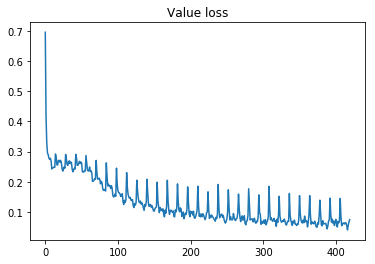

In [16]:
f, (ax1) = plt.subplots(1, 1)
ax1.plot(range(len(losses)), losses)
ax1.set_title('Value loss')

In [17]:
torch.save(model.state_dict(), 'm_embed.pt')

In [23]:
model.eval()
emb = []
for i in tqdm(movies.iterrows()):
    idx = i[1]['movieId']
    b_x = embeddings[id_to_index[idx]].to(cuda)
    preds = model.embed(b_x)
    emb.append((idx, preds))
    

In [181]:
movies = movies[:40]

In [182]:
emb = dict(emb)

In [200]:
def tsne_plot(tokens, labels):
    "Creates and TSNE model and plots it"
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=350, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    df = pd.DataFrame({'x' : x, 'y': y, 'group': [m_cat[i] for i in range(len(x))]})
    
    plt.subplots(figsize=(10,10))
    
    p = sns.regplot(x="x", y="y", data=df, fit_reg=False)
    # p.despine(left=True)
    for line in range(0,df.shape[0]):
        p.text(df.x[line]+0.02, df.y[line], df.group[line], horizontalalignment='left', size='large', color='black', weight='normal')

In [184]:
m_cat =  movies['title'].tolist()

In [185]:
cat_set = set([tuple(i) for i in m_cat])

In [186]:
len(cat_set)

40

In [187]:
ids = movies['movieId'].tolist()

In [188]:
m_embed = torch.stack([emb[i] for i in ids]).detach().cpu().numpy()

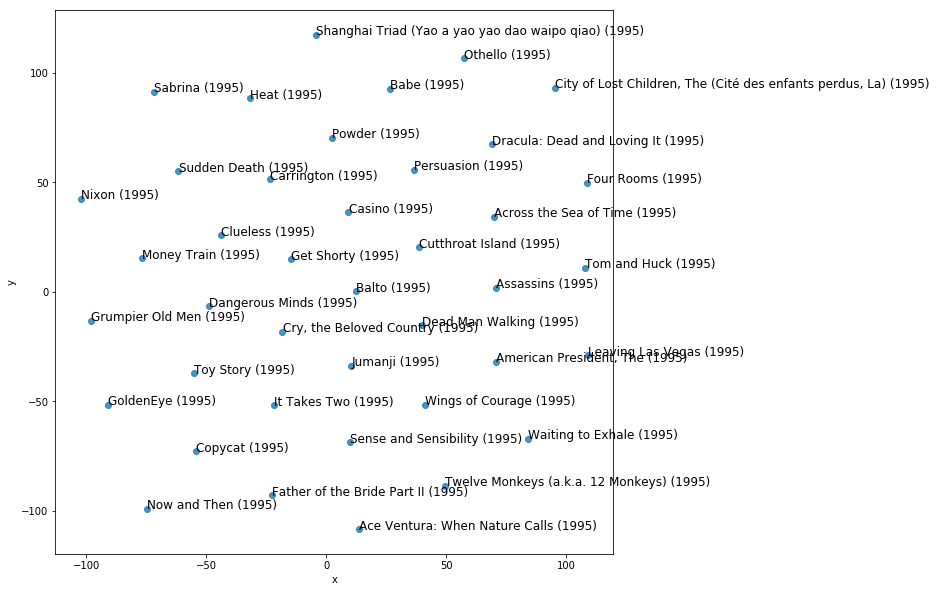

In [201]:
tsne_plot(m_embed, m_cat)

In [11]:
model = MovieEmbedder().to(cuda)

In [12]:
model.load_state_dict(torch.load('m_embed.pt'))

In [21]:
model.eval()
emb = []
for i in tqdm(movies.iterrows()):
    idx = i[1]['movieId']
    b_x = embeddings[id_to_index[idx]].to(cuda)
    preds = model.embed(b_x).detach()
    emb.append(preds)
    
emb = torch.stack(emb)

In [17]:
emb = pd.DataFrame(emb)

In [23]:
emb.size()

torch.Size([27278, 32])

In [24]:
torch.save(emb, '../data/emb32.pt')